# Pedestrian detection
[Daimler Mono Ped. Classification Benchmark Data Set](http://www.gavrila.net/Datasets/Daimler_Pedestrian_Benchmark_D/Daimler_Mono_Ped__Class__Bench/daimler_mono_ped__class__bench.html)

In [3]:
import os
from os import path
import random

import numpy as np
from PIL import Image


class PedestrianDataset:
    def __init__(self, dataset_dir: str, shuffle: bool = True):
        self.__images: list[str] = []
        self.__labels: list[str] = []
        dir_abs_route = path.abspath(dataset_dir)
        for item in os.listdir(dir_abs_route):
            subdirectory = path.join(dir_abs_route, item)
            if path.isdir(subdirectory):
                new_images = self.__get_directory_files(subdirectory)
                self.__images += new_images
                self.__labels += list([item for _ in range(len(new_images))])
        if shuffle:
            aux = list(zip(self.__images, self.__labels))
            random.shuffle(aux)
            self.__images, self.__labels = zip(*aux)

    def __getitem__(self, index: int) -> tuple[np.ndarray, str]:
        with Image.open(self.__images[index]) as image:
            image_array = np.array(image)
        label = self.__labels[index]
        return image_array, label

    def __get_directory_files(self, directory: str) -> list[str]:
        """Returns a list containing the absolute path to each file inside the directory
        """
        file_paths = []
        files = os.listdir(directory)
        for file in files:
            abs_filename = path.join(directory, file)
            file_paths.append(abs_filename)
        return sorted(file_paths)

ped_examples


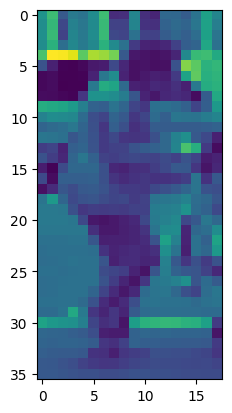

In [21]:
import matplotlib.pyplot as plt


train_dataset = PedestrianDataset("data/1")
test_dataset = PedestrianDataset("data/T1")
image, label = train_dataset[0]
print(label)
plt.imshow(image)
plt.show()

In [22]:
from skimage.feature import hog


def compute_hog_features(dataset: PedestrianDataset) -> tuple[list, list]:
    features = []
    labels = []
    for image, label in dataset:
        hog_feature = hog(image, orientations=11, pixels_per_cell=(4, 4), cells_per_block=(2, 2),
                          transform_sqrt=False, feature_vector=True)
        features.append(hog_feature)
        labels.append(label)
    return features, labels


In [23]:
train_features, train_labels = compute_hog_features(train_dataset)
test_features, test_labels = compute_hog_features(test_dataset)

                  precision    recall  f1-score   support

non-ped_examples       0.70      0.94      0.80      5000
    ped_examples       0.90      0.57      0.70      4800

        accuracy                           0.76      9800
       macro avg       0.80      0.76      0.75      9800
    weighted avg       0.80      0.76      0.75      9800



<Axes: >

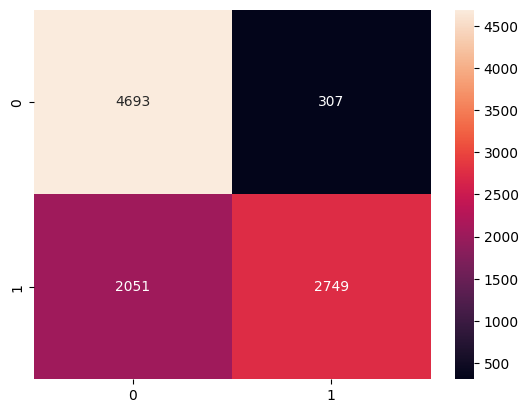

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC


pedestrian_detector = SVC()
pedestrian_detector.fit(train_features, train_labels)
predictions = pedestrian_detector.predict(test_features)
conf_matrix = confusion_matrix(test_labels, predictions)
print(classification_report(test_labels, predictions))
sns.heatmap(conf_matrix, annot=True, fmt="d")